In [209]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

In [159]:
start_df_2017 = pd.read_csv('completed_loans.csv', low_memory=False)
pd.set_option('display.max_columns', None)

In [160]:
start_df_2017.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68367011,NaN,21000.0,21000.0,21000.0,60 months,13.99%,488.53,C,C4,Resident physician,< 1 year,RENT,52000.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,441xx,OH,14.47,0.0,Jan-2005,680.0,684.0,1.0,NaN,NaN,5.0,0.0,20374.0,87.4%,15.0,w,0.0,0.0,27285.807861,27285.81,21000.0,6285.81,0.0,0.0,0.0,Aug-2018,12548.30,NaN,Jan-2020,669.0,665.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,372407.0,1.0,1.0,1.0,1.0,5.0,352033.0,NaN,0.0,0.0,9358.0,87.0,23300.0,1.0,0.0,2.0,1.0,74481.0,2926.0,87.4,0.0,0.0,76.0,131.0,85.0,5.0,0.0,85.0,NaN,0.0,NaN,0.0,3.0,3.0,4.0,4.0,11.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,370357.0,372407.0,23300.0,347057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68466926,NaN,10000.0,10000.0,10000.0,36 months,6.49%,306.45,A,A2,SERVICE MANAGER,6 years,RENT,85000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,160xx,PA,13.07,0.0,Apr-2002,685.0,689.0,1.0,NaN,106.0,14.0,1.0,10464.0,34.5%,23.0,w,0.0,0.0,10998.971575,10998.97,10000.0,998.97,0.0,0.0,0.0,Aug-2018,1814.48,NaN,Feb-2020,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,8341.0,27957.0,2.0,1.0,0.0,0.0,35.0,17493.0,57.0,2.0,7.0,2524.0,46.0,30300.0,2.0,0.0,1.0,7.0,1997.0,8182.0,50.1,0.0,0.0,164.0,129.0,1.0,1.0,1.0,4.0,NaN,1.0,NaN,0.0,6.0,9.0,7.0,10.0,3.0,13.0,19.0,9.0,14.0,0.0,0.0,0.0,2.0,95.7,28.6,1.0,0.0,61099.0,27957.0,16400.0,30799.0,NaN,NaN,NaN,

In [161]:
start_df_2017.issue_d=pd.to_datetime(start_df_2017['issue_d'])

In [162]:
time_series=start_df_2017.loc[:,['issue_d','loan_status']]

In [163]:
time_series.loan_status.replace('Charged Off',1,inplace=True)
time_series.loan_status.replace('Fully Paid',0,inplace=True)

In [180]:
#Percent of defaults per month
percents=time_series.groupby('issue_d')['loan_status'].mean()

,loan_status
issue_d,
2007-06-01,0.000000
2007-07-01,0.000000
2007-08-01,0.212121
2007-09-01,0.166667
2007-10-01,0.212766
...,...
2017-08-01,0.235923
2017-09-01,0.261546
2017-10-01,0.241081


<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x1a70a30f90>>

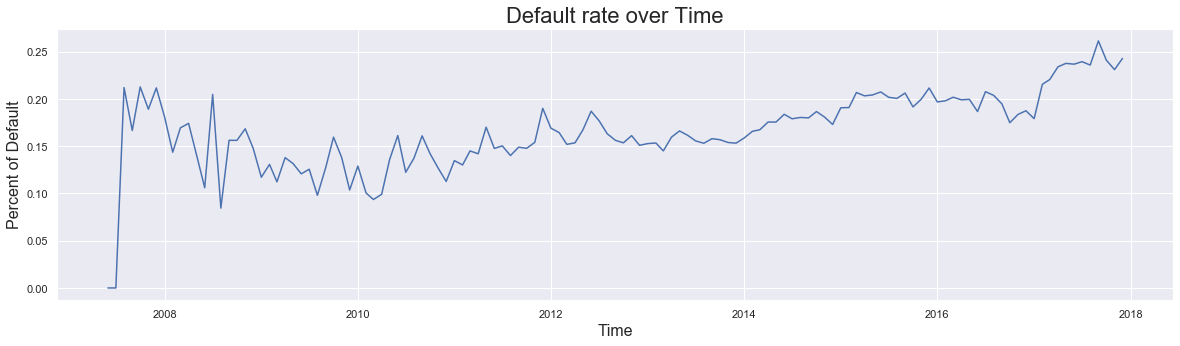

In [188]:
#Months
sns.set()
plt.figure(figsize=(20,5))
ts=sns.lineplot(x=percents.index,y=percents.values)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Percent of Default',fontsize=16)
plt.title('Default rate over Time', fontsize=22)
ts.plot

In [190]:
# Calculate The Impact of Missing Data 

In [192]:
missing=start_df_2017.loc[:,:]

In [193]:
missing.loan_status.replace('Charged Off',1,inplace=True)
missing.loan_status.replace('Fully Paid',0,inplace=True)

In [247]:
def check_null_importance(df, col):
    not_null = df.loan_status[df[col].notnull()]
    is_null = df.loan_status[df[col].isnull()]
    return is_null.mean(), not_null.mean()#, is_null.std()/np.sqrt(len(is_null)), not_null.std()/np.sqrt(len(not_null))

In [254]:
columns=missing.columns
nans=list()
for i in columns: 
    nans.append(check_null_importance(missing,i))

[(nan, 0.19393942188429386),
 (0.19393942188429386, nan),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (0.2529246168282765, 0.1899616728389029),
 (0.2580793934689929, 0.18994990344518764),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (0.19755037647902474, 0.1532121741521688),
 (nan, 0.19393942188429386),
 (0.2554561378592056, 0.19307141673836486),
 (0.0, 0.19393954963251034),
 (nan, 0.19393942188429386),
 (0.22740524781341107, 0.19393185909041794),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (nan, 0.19393942188429386),
 (0.0, 0.19393954963251034),
 (0.1875093916825941, 0.20036234889511237),
 (0.1878815